Rolling average depth change over deployment: 0.18 m
Rolling average depth change over deployment: 0.61 ft


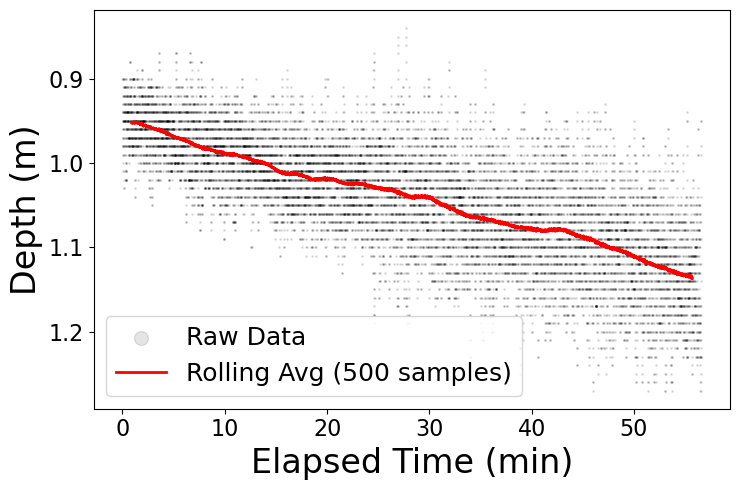

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
fname = "2025-07-29T22-37-45_clean.csv"
testName = "testElevenDuration_waves"

df = pd.read_csv(fname)

# Convert 'time' to datetime
df["time"] = pd.to_datetime(df["time"])

# Filter out negative depths
df = df[df["slowBRDepth"] >= 0].copy()

# Create a new column with elapsed time in minutes
df["elapsed_min"] = (df["time"] - df["time"].iloc[0]).dt.total_seconds() / 60

# Compute rolling average of depth over last 500 values
window = 500
df["depth_rollavg"] = df["slowBRDepth"].rolling(window=window, center=True).mean()

# Calculate the first and last valid rolling average values
first_valid = df["depth_rollavg"].iloc[window // 2]
last_valid = df["depth_rollavg"].iloc[-(window // 2 + 1)]

# Print the difference
depth_diff = last_valid - first_valid
print(f"Rolling average depth change over deployment: {depth_diff:.2f} m")
print(f"Rolling average depth change over deployment: {depth_diff*3.2808:.2f} ft")

# Set up the figure
fig, ax = plt.subplots(figsize=(7.5, 5))

# Plot raw depth data
ax.scatter(df["elapsed_min"], df["slowBRDepth"], s=1, color='black', alpha=0.1, label="Raw Data")

# Plot rolling average
ax.plot(df["elapsed_min"], df["depth_rollavg"], color='red', linewidth=2, label=f"Rolling Avg ({window} samples)")

# Label axes
ax.set_xlabel("Elapsed Time (min)", fontsize=24)
ax.set_ylabel("Depth (m)", fontsize=24)

# Set tick label size
ax.tick_params(axis='both', labelsize=16)

# Invert y-axis so surface is at the top
ax.invert_yaxis()

# Add legend with IEEE font size
ax.legend(fontsize=18,markerscale=10)

# Optional title (if you plan to include in figure caption instead, you can remove this)
# ax.set_title(testName, fontsize=20)

plt.tight_layout()
plt.savefig(f"{testName}_.jpg", dpi=600)

Rolling average depth change over deployment: 0.18 m
Rolling average depth change over deployment: 0.60 ft


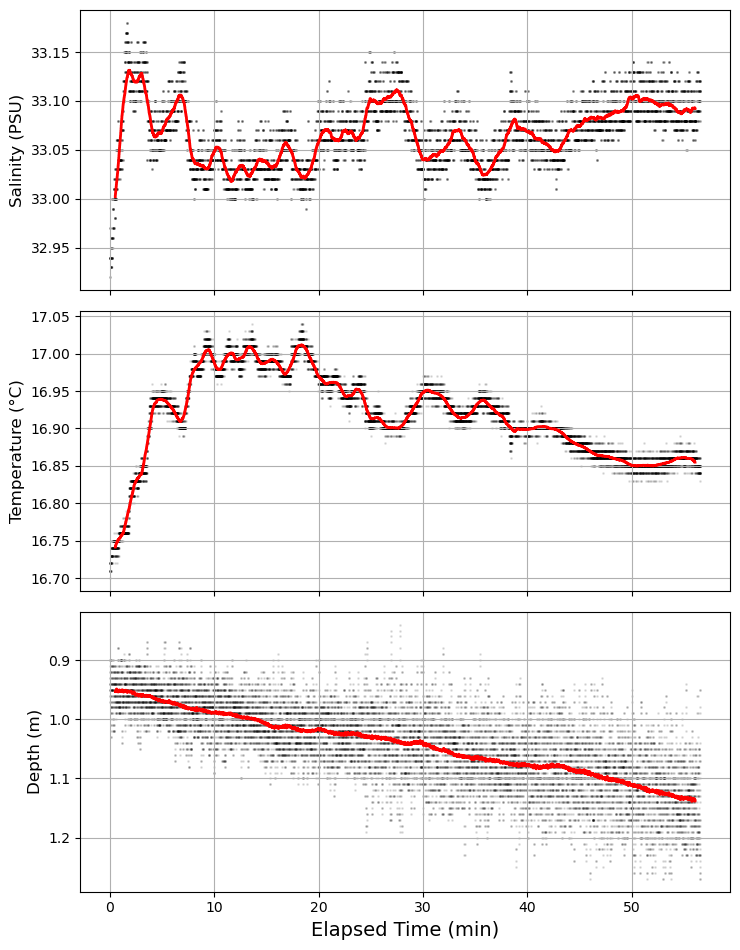

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
fname = "2025-07-29T22-37-45_clean.csv"
testName = "testElevenDuration"

df = pd.read_csv(fname)

# Convert 'time' to datetime
df["time"] = pd.to_datetime(df["time"])

# Filter out negative depths
df = df[df["slowBRDepth"] >= 0].copy()

# Create elapsed time in minutes
df["elapsed_min"] = (df["time"] - df["time"].iloc[0]).dt.total_seconds() / 60

# Set rolling window
window = 300

# Compute rolling averages
df["sal_roll"] = df["sal"].rolling(window=window, center=True).mean()
df["temp_roll"] = df["fastBRTemp"].rolling(window=window, center=True).mean()
df["depth_roll"] = df["slowBRDepth"].rolling(window=window, center=True).mean()

# Calculate and print depth change
first_valid = df["depth_roll"].iloc[window // 2]
last_valid = df["depth_roll"].iloc[-(window // 2 + 1)]
depth_diff = last_valid - first_valid
print(f"Rolling average depth change over deployment: {depth_diff:.2f} m")
print(f"Rolling average depth change over deployment: {depth_diff*3.2808:.2f} ft")

# Set up figure
fig, axs = plt.subplots(3, 1, figsize=(7.5, 10), sharex=True)
# ax.set_title(f"{testName}", fontsize=20)

# Plot styles
plot_vars = ["sal", "fastBRTemp", "slowBRDepth"]
roll_vars = ["sal_roll", "temp_roll", "depth_roll"]
ylabels = ["Salinity (PSU)", "Temperature (°C)", "Depth (m)"]

# Plot each
for ax, raw, roll, label in zip(axs, plot_vars, roll_vars, ylabels):
    ax.scatter(df["elapsed_min"], df[raw], s=1, color='black', alpha=0.1)
    ax.plot(df["elapsed_min"], df[roll], color='red', linewidth=2)
    ax.set_ylabel(label, fontsize=12)
    if raw == "slowBRDepth":
        ax.invert_yaxis()
    ax.grid(True)

# Label x-axis on bottom plot
axs[-1].set_xlabel("Elapsed Time (min)", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{testName}_sal_temp_depth.jpg", dpi=600)


C:\Users\sscop\AppData\Local\Temp\ipykernel_15004\79219731.py:47: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies


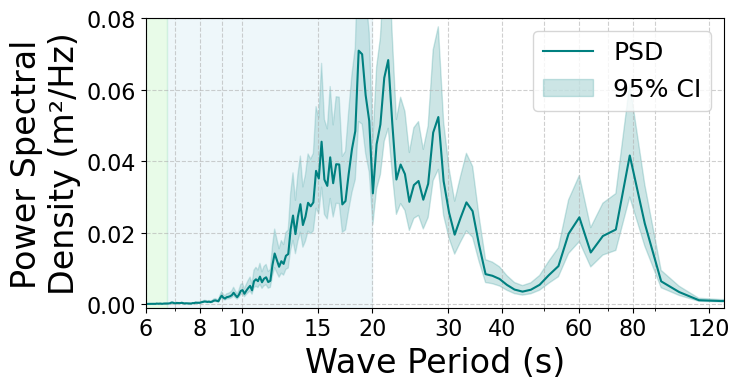

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import chi2

# --- Load and preprocess the data ---
fname = "2025-07-29T22-37-45_clean.csv"
df = pd.read_csv(fname)

df["time"] = pd.to_datetime(df["time"])
df = df[df["slowBRDepth"] >= 0].copy()

# Compute elapsed time in seconds
df["elapsed_sec"] = (df["time"] - df["time"].iloc[0]).dt.total_seconds()

# Define window in seconds
detrend_window_sec = 300  # or 480 for more conservative detrending

# Convert to number of samples
window_samples = int(detrend_window_sec / dt)

# Apply rolling mean detrend
depth_signal = df["slowBRDepth"].rolling(window=window_samples, center=True).mean()
detrended = df["slowBRDepth"] - depth_signal
detrended_clean = detrended.dropna().values

# Sampling frequency (Hz)
elapsed_sec = df["elapsed_sec"]
valid_diffs = elapsed_sec.diff().dropna()
valid_diffs = valid_diffs[valid_diffs > 0]
dt = valid_diffs.median()
fs = 1 / dt

# Welch PSD Estimate
nperseg = 1024
frequencies, psd = welch(detrended_clean, fs=fs, nperseg=nperseg)

# Confidence Interval Calculation (95%)
n_segments = int((len(detrended_clean) - nperseg // 2) / (nperseg // 2))
dof = 2 * n_segments
alpha = 0.05
ci_lower = psd * dof / chi2.ppf(1 - alpha / 2, dof)
ci_upper = psd * dof / chi2.ppf(alpha / 2, dof)

# Convert frequency to wave period (s)
periods = 1 / frequencies

# --- Plot PSD vs Period (log scale) ---
fig, ax = plt.subplots(figsize=(7.5, 4))

# Plot PSD and confidence interval
ax.plot(periods, psd, color='teal', label="PSD")
ax.fill_between(periods, ci_lower, ci_upper, color='teal', alpha=0.2, label="95% CI")

# Axis formatting
ax.set_xlabel("Wave Period (s)",fontsize=24)
ax.set_ylabel("Power Spectral\nDensity (m²/Hz)",fontsize=24)
ax.set_xscale("log")
# ax.set_title("Welch PSD by Period with 95% Confidence Interval")
ax.grid(True, which="both", linestyle="--", alpha=0.6)

# Custom ticks
period_ticks = [6, 8, 10, 15, 20, 30, 40, 60, 80, 120]
ax.set_xticks(period_ticks)
ax.set_xticklabels([str(p) for p in period_ticks])
ax.tick_params(labelsize=16)

# Overlay common wave period bands
for band, color in [((2.5, 6.7), 'lightgreen'), ((6.7, 20), 'lightblue')]:
    ax.axvspan(*band, color=color, alpha=0.2)

ax.set_xlim(6, 130)
ax.set_ylim(-0.001,0.08)
ax.legend(fontsize=18)

plt.tight_layout()
plt.savefig("PSD_plot.png",dpi=600)

In [2]:
# Step 1: Convert time column to datetime (adjust format if needed)
df["time"] = pd.to_datetime(df["time"])

# Step 2: Compute time differences in seconds
time_deltas = df["time"].diff().dt.total_seconds()

# Step 3: Compute average sampling interval and frequency
avg_interval = time_deltas.mean()
sampling_frequency_hz = 1 / avg_interval

# Step 4: Compute total duration in minutes
total_duration = (df["time"].iloc[-1] - df["time"].iloc[0]).total_seconds()
total_duration_minutes = total_duration / 60

print(f"Average sampling frequency: {sampling_frequency_hz:.2f} Hz")
print(f"Total duration: {total_duration_minutes:.2f} minutes")

# raw is 8.4min
# cast is 2.6min

# 68KB for clean file at 5hz is how many bytes a second

file_size_bytes = 68 * 1024  # 68 KB to bytes
duration_seconds = 2.6 * 60  # minutes to seconds

bytes_per_second = file_size_bytes / duration_seconds
print(f"Bytes per second: {bytes_per_second:.2f} B/s")

# Estimate time to fill a 256MB SD card
sd_card_size_bytes = 256 * 1024 * 1024  # 256 MB in bytes
time_to_fill_seconds = sd_card_size_bytes / bytes_per_second
time_to_fill_minutes = time_to_fill_seconds / 60
time_to_fill_hours = time_to_fill_minutes / 60
time_to_fill_days = time_to_fill_hours / 24

print(f"Estimated time to fill 256MB SD card:")
print(f"  {time_to_fill_seconds:.0f} seconds")
print(f"  {time_to_fill_minutes:.1f} minutes")
print(f"  {time_to_fill_hours:.2f} hours")
print(f"  {time_to_fill_days:.2f} days")

sd_card_size_bytes = 256 * 1024 * 1024  # 256 MB
bytes_per_sample = 460 / 5  # ≈ 92 B/sample
sampling_interval_seconds = 60  # 1 sample per minute

bytes_per_second = bytes_per_sample / sampling_interval_seconds  # ≈ 1.53 B/s

# Time to fill
time_to_fill_seconds = sd_card_size_bytes / bytes_per_second
time_to_fill_minutes = time_to_fill_seconds / 60
time_to_fill_hours = time_to_fill_minutes / 60
time_to_fill_days = time_to_fill_hours / 24

print(f"Estimated time to fill 256MB SD card at 1 sample/minute (~{bytes_per_second:.2f} B/s):")
print(f"  {time_to_fill_minutes:,.0f} minutes")
print(f"  {time_to_fill_hours:,.1f} hours")
print(f"  {time_to_fill_days:,.2f} days")

Average sampling frequency: 4.77 Hz
Total duration: 56.57 minutes
Bytes per second: 446.36 B/s
Estimated time to fill 256MB SD card:
  601389 seconds
  10023.2 minutes
  167.05 hours
  6.96 days
Estimated time to fill 256MB SD card at 1 sample/minute (~1.53 B/s):
  2,917,777 minutes
  48,629.6 hours
  2,026.23 days
